In [1]:
import mediapipe as mp
import cv2
import numpy as np

In [9]:
video_path = r"E:\Lip_Wise_GFPGAN\_testData\Inputs\test_trim.mp4"
detector_model_path = r"E:\Lip_Wise\weights\mp\blaze_face_short_range.tflite"
landmarker_model_path = r"E:\Lip_Wise\weights\mp\face_landmarker.task"
direct = r"E:\Lip_Wise\Result_Analytics\Cropped_face"

In [8]:
video = cv2.VideoCapture(video_path)

# Get video properties
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize mediapipe
BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions

FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions

# Create a face detector instance with the image mode:
options_det = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path=detector_model_path),
    min_detection_confidence=0.5,
    running_mode=VisionRunningMode.IMAGE)


options_lan = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=landmarker_model_path),
    min_face_detection_confidence=0.5,
    running_mode=VisionRunningMode.IMAGE)

frame_no = 0
no_face_index = []

with FaceLandmarker.create_from_options(options_lan) as landmarker,FaceDetector.create_from_options(options_det) as detector:
    while video.isOpened() and frame_no < 160:

        ret, frame = video.read()
        
        if not ret:
            break

        # Convert frame to RGB and convert to MediaPipe image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # Run face detector and face landmark models in IMAGE mode
        result_landmarker = landmarker.detect(mp_frame)
        result_detection = detector.detect(mp_frame)
        
        if len(result_detection.detections) > 0 and len(result_landmarker.face_landmarks) > 0:

            # Get landmarks
            landmarks_np = np.array([[i.x, i.y] for i in result_landmarker.face_landmarks[0]]).astype(np.float64)

            # Get bounding box
            # x-coordinates are at even indices and y-coordinates are at odd indices
            x_coordinates = landmarks_np[:, 0]
            y_coordinates = landmarks_np[:, 1]

            # Top-most point has the smallest y-coordinate
            y_min = landmarks_np[np.argmin(y_coordinates)]

            # Bottom-most point has the largest y-coordinate
            y_max = landmarks_np[np.argmax(y_coordinates)]

            # Left-most point has the smallest x-coordinate
            x_min = landmarks_np[np.argmin(x_coordinates)]

            # Right-most point has the largest x-coordinate
            x_max = landmarks_np[np.argmax(x_coordinates)]

            bbox_np = np.array([[x_min[0], y_min[1]], [x_max[0], y_max[1]]]).astype(np.float64)
            bbox_np = bbox_np * [frame.shape[1], frame.shape[0]]

            # Crop face
            if frame_no%16 == 0:
                face = frame[int(bbox_np[0, 1]):int(bbox_np[1, 1]), int(bbox_np[0, 0]):int(bbox_np[1, 0])]
                face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                face = cv2.resize(face, (96, 96))
                # face = cv2.resize(face, (512, 512), interpolation=cv2.INTER_LANCZOS4)
                cv2.imwrite(direct + f"\\{frame_no//16}.jpg", face)
    
        # Increment frame number
        frame_no += 1

    # Release video
    video.release()

In [16]:
import torch

from facexlib.utils import load_file_from_url
from facexlib.parsing.bisenet import BiSeNet
from facexlib.parsing.parsenet import ParseNet

def init_parsing_model(model_name='bisenet', half=False, device='cuda', model_rootpath=None):
    if model_name == 'bisenet':
        model = BiSeNet(num_class=19)
        model_url = 'https://github.com/xinntao/facexlib/releases/download/v0.2.0/parsing_bisenet.pth'
    elif model_name == 'parsenet':
        model = ParseNet(in_size=512, out_size=512, parsing_ch=19)
        model_url = 'https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth'
    else:
        raise NotImplementedError(f'{model_name} is not implemented.')

    model_path = load_file_from_url(
        url=model_url, model_dir='facexlib/weights', progress=True, file_name=None, save_dir=model_rootpath)
    load_net = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(load_net, strict=True)
    model.eval()
    model = model.to(device)
    return model

In [17]:
from torchvision.transforms.functional import normalize
from facexlib.utils.misc import img2tensor, imwrite

In [18]:
def paste_face_to_input_image_with_soft_mask(restored_face, inverse_affine, input_image, upscale_factor):

    h, w, _ = input_image.shape
    h_up, w_up = int(h * upscale_factor), int(w * upscale_factor)

    face_parse = init_parsing_model()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    upscale_img = cv2.resize(input_image, (w_up, h_up), interpolation=cv2.INTER_LANCZOS4)
    warped_face = cv2.warpAffine(restored_face, inverse_affine, (w_up, h_up))

    # Generate a soft mask for the restored face using face parsing.
    face_input = cv2.resize(restored_face, (512, 512), interpolation=cv2.INTER_LINEAR)
    face_input = img2tensor(face_input.astype('float32') / 255., bgr2rgb=True, float32=True)
    normalize(face_input, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    face_input = torch.unsqueeze(face_input, 0).to(device)
    with torch.no_grad():
        out = face_parse(face_input)[0]
    out = out.argmax(dim=1).squeeze().cpu().numpy()

    mask = np.zeros(out.shape)
    MASK_COLORMAP = [0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0]
    for idx, color in enumerate(MASK_COLORMAP):
        mask[out == idx] = color

    # Blur the mask.
    mask = cv2.GaussianBlur(mask, (101, 101), 11)
    mask = cv2.GaussianBlur(mask, (101, 101), 11)

    # Remove the black borders.
    thres = 10
    mask[:thres, :] = 0
    mask[-thres:, :] = 0
    mask[:, :thres] = 0
    mask[:, -thres:] = 0
    mask = mask / 255.

    warped_mask = cv2.warpAffine(mask, inverse_affine, (w_up, h_up), flags=3)
    inv_soft_mask = warped_mask[:, :, None]

    # Blend the restored face with the upscaled input image using the soft mask.
    blended_image = inv_soft_mask * warped_face + (1 - inv_soft_mask) * upscale_img

    # Convert the blended image to the original data type (e.g., uint8 for 8-bit images).
    blended_image = blended_image.astype(np.uint8)

    return blended_image

In [19]:
output = paste_face_to_input_image_with_soft_mask(img, np.eye(2,3).astype(np.float32), bk_img, 1)

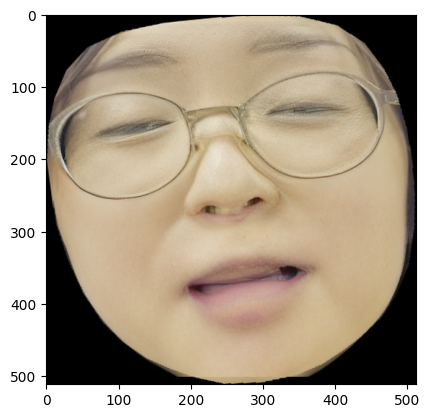

In [20]:
plt.imshow(output[:,:,::-1])

In [21]:
import helpers.model_loaders as ml

mlo = ml.ModelLoader(restorer='VQFR2', weight=0)

final = mlo.restore_background(output, 2)



	Tile 1/1


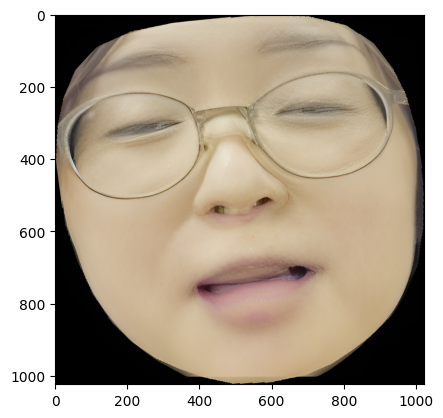

In [22]:
plt.imshow(final[:,:,::-1])